In [1]:
import joblib
import json
import pandas as pd
import numpy as np
import utils
from transformers import AutoTokenizer
import torch
import sys
from collections import Counter

sys.path.append("../datasets")
import configs

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
dataset = "dbpedia"
architecture = "BART"
data_dir = f"../datasets/{dataset}_dataset"
batch_size = 256
model_name = f"{dataset}_model_0.9_0.9_0.9"

In [3]:
if architecture == "BART":
    tokenizer = AutoTokenizer.from_pretrained("ModelTC/bart-base-mnli")
elif architecture == "ELECTRA":
    tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
else:
    print(f"Invalid backbone architecture: {architecture}")

In [4]:
all_datasets = utils.load_dataset(
    data_dir=data_dir,
    tokenizer=tokenizer,
    max_length=configs.dataset_to_max_length[dataset],
)

all_dataloaders = {
    dataset_name: torch.utils.data.DataLoader(
        all_datasets[dataset_name],
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: {
            "input_ids": torch.LongTensor([i["input_ids"] for i in batch]),
            "attention_mask": torch.Tensor([i["attention_mask"] for i in batch]),
            "label": torch.LongTensor([i["label"] for i in batch]),
        },
    )
    for dataset_name in all_datasets.keys()
    if dataset_name != "train"
}

Train data shape:  (24094, 2)


Map:   0%|          | 0/24094 [00:00<?, ? examples/s]

Map:   0%|          | 0/60794 [00:00<?, ? examples/s]

Map:   0%|          | 0/1836 [00:00<?, ? examples/s]

Map:   0%|          | 0/1281 [00:00<?, ? examples/s]

Map:   0%|          | 0/1836 [00:00<?, ? examples/s]

Map:   0%|          | 0/1281 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
bestk_train_data_per_proto = joblib.load(
    f"artifacts/{dataset}/{model_name}/bestk_train_data_per_proto.joblib"
)

best_protos_per_traineg = joblib.load(
    f"artifacts/{dataset}/{model_name}/best_protos_per_traineg.joblib"
)

In [6]:
num_prototypes = bestk_train_data_per_proto.indices.shape[1]
num_training_examples = best_protos_per_traineg[0].shape[0]

In [7]:
sorted(
    dict(Counter(all_datasets["test"]["label"])).items(),
    key=lambda x: x[1],
    reverse=True,
)

[(0, 31495),
 (2, 11574),
 (3, 5418),
 (1, 5300),
 (5, 4820),
 (6, 1483),
 (4, 444),
 (8, 198),
 (7, 62)]

In [8]:
configs.dbpedia_dataset_labels2ids

{'Agent': 0,
 'Work': 1,
 'Place': 2,
 'Species': 3,
 'UnitOfWork': 4,
 'Event': 5,
 'SportsSeason': 6,
 'Device': 7,
 'TopicalConcept': 8}

In [9]:
from collections import defaultdict

indices = bestk_train_data_per_proto.indices.reshape(num_prototypes, -1).tolist()
values = bestk_train_data_per_proto.values.reshape(num_prototypes, -1).tolist()

indices_values_for_all_prototypes = []
for i in range(num_prototypes):
    indices_values_per_prototype = list(zip(indices[i], values[i]))
    indices_values_per_prototype.sort(key=lambda x: x[1], reverse=False)
    indices_values_for_all_prototypes.append(indices_values_per_prototype)

labels_score = defaultdict(int)

for i in range(num_prototypes):
    print(f"Prototype {i}")
    training_examples_indices = np.array(
        [x[0] for x in indices_values_for_all_prototypes[i]]
    )
    training_examples_distances = np.array(
        [x[1] for x in indices_values_for_all_prototypes[i]]
    )
    training_labels_for_prototype = np.array(all_datasets["test"]["label"])[
        training_examples_indices
    ]
    print(training_labels_for_prototype)
    for rank, label in enumerate(training_labels_for_prototype):
        labels_score[label] += 1 / 5
    # print(np.array(all_datasets["test"]["text"])[training_examples_indices])
    print(training_examples_distances)
    print("------------------")
print("labels_score")
print(labels_score)

Prototype 0
[0 0 0 0 2]
[-3.86000395 -3.8521657  -3.84659767 -3.8372066  -3.80397987]
------------------
Prototype 1
[1 0 3 0 0]
[-3.84467077 -3.83111954 -3.79959321 -3.7980237  -3.76843357]
------------------
Prototype 2
[0 5 0 6 0]
[-3.84857941 -3.84825969 -3.83848882 -3.80562568 -3.41503525]
------------------
Prototype 3
[0 5 0 1 2]
[-3.85732651 -3.84428358 -3.84127998 -3.83616781 -3.80349612]
------------------
Prototype 4
[0 2 1 0 0]
[-3.84601855 -3.84326577 -3.82910824 -3.79504251 -3.78783989]
------------------
Prototype 5
[0 0 0 3 1]
[-3.84707737 -3.84617877 -3.83714962 -3.76204228 -3.41468787]
------------------
Prototype 6
[5 0 5 2 3]
[-3.85466504 -3.8411448  -3.83814526 -3.83546615 -3.79589629]
------------------
Prototype 7
[2 3 0 5 3]
[-3.84377384 -3.83243132 -3.8015604  -3.79333043 -3.78693724]
------------------
Prototype 8
[3 0 3 0 4]
[-3.84385467 -3.83619356 -3.82836747 -3.75422311 -3.41041017]
------------------
Prototype 9
[0 3 2 2 1]
[-3.84332275 -3.83947897 -3.837

In [101]:
indices = best_protos_per_traineg[0].tolist()
values = best_protos_per_traineg[1].tolist()

prototypes_and_distances_to_examples_sorted = []
for i in range(num_training_examples):
    indices_values_per_training_example = list(zip(indices[i], values[i]))
    indices_values_per_training_example.sort(key=lambda x: x[1], reverse=False)
    prototypes_and_distances_to_examples_sorted.append(
        indices_values_per_training_example
    )

prototypes_and_distances_to_examples_sorted = np.array(
    prototypes_and_distances_to_examples_sorted
)

In [102]:
import matplotlib.pyplot as plt

In [103]:
closest_prototypes_to_test_examples_stats = dict(
    sorted(
        dict(
            Counter(prototypes_and_distances_to_examples_sorted[:, 0, 0].tolist())
        ).items(),
        key=lambda x: x[1],
        reverse=True,
    )
)
closest_prototypes_to_test_examples_stats

{2.0: 5254,
 15.0: 4832,
 5.0: 4642,
 8.0: 4625,
 14.0: 4538,
 13.0: 4243,
 1.0: 3963,
 0.0: 3862,
 12.0: 3785,
 7.0: 3467,
 9.0: 3307,
 4.0: 3211,
 11.0: 2980,
 3.0: 2952,
 6.0: 2882,
 10.0: 2251}

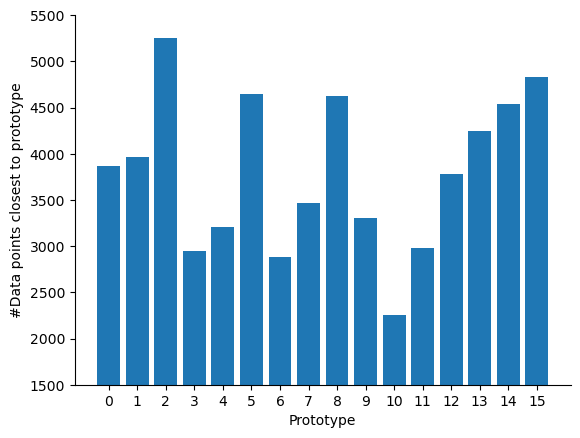

In [104]:
### make a distribution plot from the above with spaces between the bars
plt.bar(
    list(closest_prototypes_to_test_examples_stats.keys()),
    list(closest_prototypes_to_test_examples_stats.values()),
)
# add the xticks
plt.xticks(list(closest_prototypes_to_test_examples_stats.keys()))

# remove the top and right spines from plot
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# plt.title("Distribution of number of prototypes closest to training examples")
plt.xlabel("Prototype")
plt.ylabel("#Data points closest to prototype")

plt.ylim(1500, 5500)

plt.savefig(
    "../figures/prototypes_number_of_datapoints_closest_to_prototype_dist.png", dpi=500
)

plt.show()

In [105]:
model = utils.load_model("dbpedia_model_0.9_0.9_0.9", 16, "BART", "dbpedia")

ProtoTEx best model: 16
Using backone: BART


Some weights of the model checkpoint at ModelTC/bart-base-mnli were not used when initializing BartForConditionalGeneration: ['classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.bias']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading model checkpoint: Models/dbpedia_model_0.9_0.9_0.9
Skipping weights for: loss_fn.weight


In [106]:
model.classfn_model.weight.shape

torch.Size([9, 16])

In [107]:
model.classfn_model.weight[0], np.argsort(model.classfn_model.weight[0].tolist())

(tensor([ 1.0616, -0.6642, -1.0115,  0.2810, -0.7151, -0.7977,  0.4659, -0.3716,
         -0.5645, -0.4645,  0.4588, -0.1520,  0.9578, -0.7280, -0.0200,  0.9800],
        grad_fn=<SelectBackward0>),
 array([ 2,  5, 13,  4,  1,  8,  9,  7, 11, 14,  3, 10,  6, 12, 15,  0]))

In [133]:
prototypes_and_distances_to_examples_sorted.shape

(60794, 16, 2)

In [216]:
prototypes_and_distances_to_examples_sorted[
    0, 0, 1
], prototypes_and_distances_to_examples_sorted[0, -1, 1]

array([-3.79599667, -0.10770952, -0.00999027,  0.02168385,  0.13249105,
        0.15947689,  0.16542596,  0.21255514,  0.21273048,  0.25009066,
        0.26976225,  0.337327  ,  0.50356704,  0.50578386,  0.51689297,
        0.62588   ])

In [196]:
closest_prototypes_indices = prototypes_and_distances_to_examples_sorted[:, :, 0]
closest_prototypes_indices

array([[ 4.,  8.,  5., ...,  3.,  6.,  0.],
       [ 7.,  2.,  1., ..., 12., 10.,  0.],
       [ 0.,  2.,  1., ..., 11.,  9., 10.],
       ...,
       [ 4.,  8.,  2., ..., 12.,  0.,  6.],
       [ 2.,  5.,  8., ..., 12.,  0.,  6.],
       [ 0.,  2., 14., ..., 11.,  9., 10.]])

In [197]:
most_effective_prototype_in_each_class_prediction = []
for i in range(9):
    weights = model.classfn_model.weight[i].detach().numpy().tolist()
    most_effective_prototype_in_each_class_prediction.append(
        np.argsort(weights)[:].tolist()
    )
most_effective_prototype_in_each_class_prediction

[[2, 5, 13, 4, 1, 8, 9, 7, 11, 14, 3, 10, 6, 12, 15, 0],
 [12, 11, 3, 1, 8, 7, 2, 15, 14, 6, 9, 10, 0, 13, 5, 4],
 [0, 2, 1, 4, 3, 6, 13, 14, 12, 11, 7, 9, 15, 8, 5, 10],
 [5, 13, 14, 7, 0, 8, 15, 3, 10, 11, 6, 1, 12, 9, 2, 4],
 [6, 4, 0, 5, 15, 9, 12, 14, 11, 10, 13, 3, 2, 8, 1, 7],
 [15, 2, 6, 3, 14, 1, 8, 10, 7, 11, 12, 0, 4, 5, 13, 9],
 [9, 1, 10, 0, 2, 15, 6, 8, 7, 14, 13, 3, 12, 11, 5, 4],
 [7, 3, 0, 15, 8, 10, 4, 12, 9, 1, 2, 13, 6, 5, 14, 11],
 [10, 6, 3, 2, 11, 5, 7, 8, 4, 12, 0, 14, 1, 15, 13, 9]]

In [198]:
prototypes_and_distances_to_examples = []
indices = best_protos_per_traineg[0].tolist()
values = best_protos_per_traineg[1].tolist()

for i in range(num_training_examples):
    prototype_and_distance_for_one_example = list(zip(indices[i], values[i]))
    prototype_and_distance_for_one_example.sort(key=lambda x: x[0], reverse=False)
    prototypes_and_distances_to_examples.append(prototype_and_distance_for_one_example)

prototypes_and_distances_to_examples = np.array(prototypes_and_distances_to_examples)

In [199]:
prototypes_being_actually_used = []
for input_example_index in range(num_training_examples):
    predicted_class = np.argmax(
        np.dot(
            model.classfn_model.weight.detach().cpu().numpy(),
            prototypes_and_distances_to_examples[input_example_index, :, 1],
        )
    )
    prototypes_being_actually_used.append(
        most_effective_prototype_in_each_class_prediction[predicted_class]
    )
prototypes_being_actually_used = np.array(prototypes_being_actually_used)

In [213]:
number_of_prototypes_used = 2
k_for_precision_at_k = 2

precision_at_k_for_all_data_points = []
for i in range(num_training_examples):
    x = 0
    for k in range(1, k_for_precision_at_k + 1):
        x += (
            len(
                set.intersection(
                    set(closest_prototypes_indices[i][:number_of_prototypes_used]),
                    set(prototypes_being_actually_used[i][:k]),
                )
            )
            / k
        )
    precision_at_k_for_all_data_points.append(x / number_of_prototypes_used)


print(
    "Precision at k - {}, and number of prototypes - {}, for all data points: ".format(
        k_for_precision_at_k, number_of_prototypes_used
    ),
    sum(precision_at_k_for_all_data_points) / num_training_examples,
)

Precision at k - 2, and number of prototypes - 2, for all data points:  0.6542874296805605


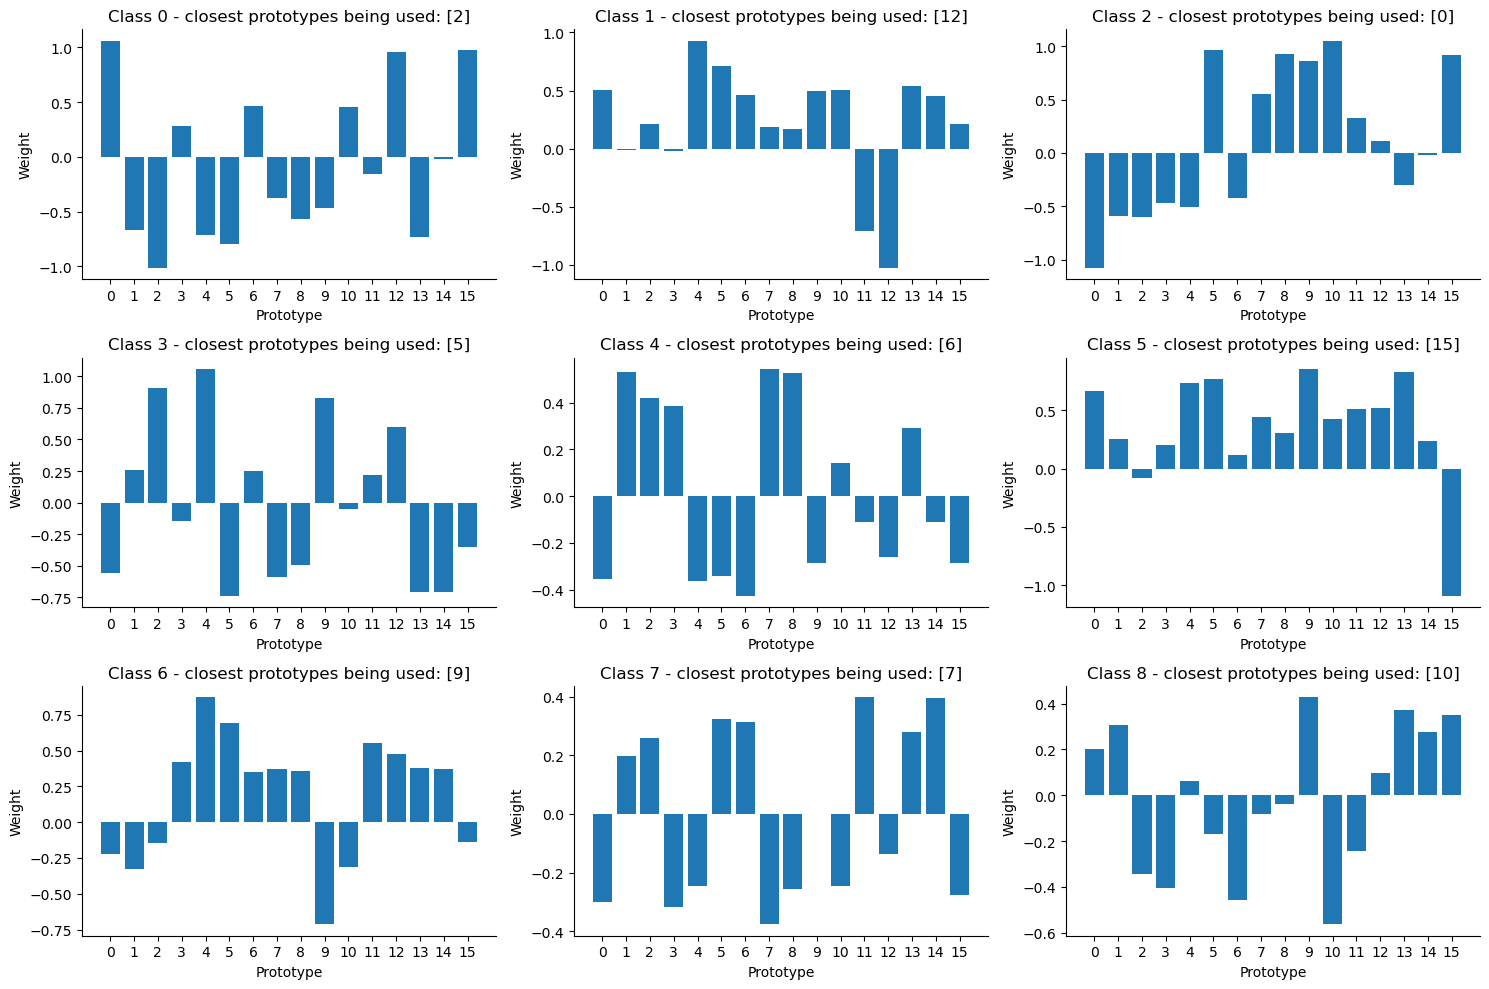

In [45]:
# for each index in the model.classfn_model.weight which means 9 indices or classes, show the contribution of each prototype by its weight in a bar plot

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for ax_index, ax in enumerate(axs.flatten()):
    weights = model.classfn_model.weight[ax_index].detach().numpy().tolist()
    ax.bar(
        list(range(16)),
        weights,
    )
    closest_prototypes_being_used = np.argsort(weights)[:1]
    # farthest_prototypes_being_used = np.argsort(weights)[-2:]
    ax.set_xticks(list(range(16)))
    ax.set_title(
        f"Class {ax_index} - closest prototypes being used: {closest_prototypes_being_used}"
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # assign labels for x axis and y axis
    ax.set_xlabel("Prototype")
    ax.set_ylabel("Weight")
plt.tight_layout()
plt.show()

In [78]:
best_protos_per_testeg = joblib.load(
    f"artifacts/{dataset}/{model_name}/best_protos_per_testeg.joblib"
)

In [79]:
best_protos_per_testeg.keys()

dict_keys(['test_textfooler', 'test_textbugger', 'adv_textfooler', 'adv_textbugger', 'test_textfooler_protocnn', 'adv_textfooler_protocnn', 'test_textbugger_protocnn', 'adv_textbugger_protocnn', 'adv_paraphrased', 'test_paraphrased'])

In [91]:
dataset_name = "{}_textbugger"

prototoypes_indices_values_per_point_test = []
prototoypes_indices_values_per_point_adv = []
test_predictions = np.array(
    best_protos_per_testeg[dataset_name.format("test")][2].tolist()
)
adv_predictions = np.array(
    best_protos_per_testeg[dataset_name.format("adv")][2].tolist()
)
true_labels = np.array(all_datasets[dataset_name.format("test")]["label"])


for split in ["test", "adv"]:
    for i in range(len(all_datasets[dataset_name.format(split)])):
        indices = best_protos_per_testeg[dataset_name.format(split)][0].tolist()
        values = best_protos_per_testeg[dataset_name.format(split)][1].tolist()

        indices_values_per_training_example = list(zip(indices[i], values[i]))
        indices_values_per_training_example.sort(key=lambda x: x[1], reverse=False)

        if split == "test":
            prototoypes_indices_values_per_point_test.append(
                indices_values_per_training_example
            )
        else:
            prototoypes_indices_values_per_point_adv.append(
                indices_values_per_training_example
            )
prototoypes_indices_values_per_point_test = np.array(
    prototoypes_indices_values_per_point_test
)
prototoypes_indices_values_per_point_adv = np.array(
    prototoypes_indices_values_per_point_adv
)

In [102]:
closest_prototypes_used_for_test = prototoypes_indices_values_per_point_test[:, 0, 0]
closest_prototypes_used_for_adv = prototoypes_indices_values_per_point_adv[:, 0, 0]

In [103]:
indices_where_adv_predictions_are_wrong = np.where(adv_predictions != true_labels)[0]

In [104]:
indices_where_test_and_adv_predictions_differ = np.where(
    test_predictions != adv_predictions
)[0]
indices_where_test_and_adv_predictions_differ.shape, test_predictions.shape

((282,), (1281,))

In [109]:
indices_where_prototypes_used_differ = np.where(
    closest_prototypes_used_for_test != closest_prototypes_used_for_adv
)[0]
indices_where_prototypes_used_same = np.where(
    closest_prototypes_used_for_test == closest_prototypes_used_for_adv
)[0]

In [112]:
print(
    "Ratio of the wrong predictions because of changed prototypes to the total number of wrong predictions:",
    len(
        np.intersect1d(
            indices_where_prototypes_used_differ,
            indices_where_adv_predictions_are_wrong,
        )
    )
    / len(indices_where_adv_predictions_are_wrong),
)

Ratio of the wrong predictions because of changed prototypes to the total number of wrong predictions: 0.7373737373737373


In [113]:
distances_for_test_examples_with_unchanged_prototypes_wrong_predictions = (
    prototoypes_indices_values_per_point_test[
        np.intersect1d(
            indices_where_prototypes_used_same, indices_where_adv_predictions_are_wrong
        ),
        0,
        1,
    ]
)
distances_for_adv_examples_with_unchanged_prototypes_wrong_predictions = (
    prototoypes_indices_values_per_point_adv[
        np.intersect1d(
            indices_where_prototypes_used_same,
            indices_where_adv_predictions_are_wrong,
        ),
        0,
        1,
    ]
)

In [117]:
distances_for_test_examples_with_unchanged_prototypes_wrong_predictions.shape

(78,)

In [119]:
print(
    "The number of instances in which the prototypes used are the same but the distance has increased:"
)
len(
    np.where(
        distances_for_test_examples_with_unchanged_prototypes_wrong_predictions
        < distances_for_adv_examples_with_unchanged_prototypes_wrong_predictions
    )[0]
) / len(
    np.intersect1d(
        indices_where_prototypes_used_same,
        indices_where_adv_predictions_are_wrong,
    )
)

The number of instances in which the prototypes used are the same but the distance has increased:


0.44871794871794873

In [22]:
import torch
import matplotlib.pyplot as plt

In [16]:
all_prototypes = torch.load(f"artifacts/{dataset}/{model_name}/all_protos.pt")
all_prototypes = torch.Tensor(all_prototypes.reshape(16, -1))

In [19]:
pairwise_distances = torch.cdist(all_prototypes, all_prototypes, p=2)

In [29]:
mapping_so_far = [
    "Specific locations, institutions",
    "Geographical locations or infrastructure",
    "Numerical entities",
    "Location, facility, or organization",
    "Organizations, Locations, or Facilities",
    "Location, facility, or organization",
    "Specific dates or years associated with events, births, etc",
    "Entities or Proper Nouns",
    "Historical Background in detail",
    "Specific geographical locations or places",
    "Unclear",
    "Publication information / Journals, etc",
    "Publications or Magazines",
    "Unclear",
    "Locations or Facilities",
    "Events / races",
]
mapping_so_far

['Specific locations, institutions',
 'Geographical locations or infrastructure',
 'Numerical entities',
 'Location, facility, or organization',
 'Organizations, Locations, or Facilities',
 'Location, facility, or organization',
 'Specific dates or years associated with events, births, etc',
 'Entities or Proper Nouns',
 'Historical Background in detail',
 'Specific geographical locations or places',
 'Unclear',
 'Publication information / Journals, etc',
 'Publications or Magazines',
 'Unclear',
 'Locations or Facilities',
 'Events / races']

In [33]:
for i in range(16):
    print("prototype", mapping_so_far[i], i)
    print("the closest prototypes are:")
    closest_prototypes = np.argsort(pairwise_distances[i].detach().numpy())[1:3]
    print([mapping_so_far[x] for x in closest_prototypes])
    print("------------------")

prototype Specific locations, institutions 0
the closest prototypes are:
['Unclear', 'Location, facility, or organization']
------------------
prototype Geographical locations or infrastructure 1
the closest prototypes are:
['Unclear', 'Specific geographical locations or places']
------------------
prototype Numerical entities 2
the closest prototypes are:
['Unclear', 'Specific geographical locations or places']
------------------
prototype Location, facility, or organization 3
the closest prototypes are:
['Unclear', 'Specific geographical locations or places']
------------------
prototype Organizations, Locations, or Facilities 4
the closest prototypes are:
['Unclear', 'Specific geographical locations or places']
------------------
prototype Location, facility, or organization 5
the closest prototypes are:
['Specific geographical locations or places', 'Unclear']
------------------
prototype Specific dates or years associated with events, births, etc 6
the closest prototypes are:
['Unc

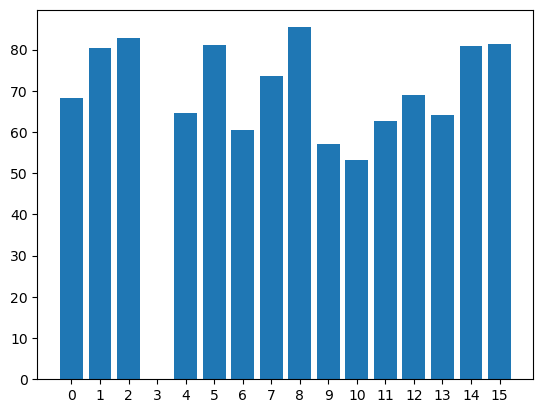

In [25]:
plt.bar(np.arange(16), pairwise_distances[3])
plt.xticks(np.arange(16))
plt.show()